In [6]:
import sys
!{sys.executable} -m pip install squarify

In [7]:
#states under consideration: Illinois, Florida, Oregon, New Hampshire, Colorado, California, New Jersey, Arizona

In [8]:
import scipy.stats
import matplotlib.pyplot as plt
import copy
from sklearn import linear_model

import matplotlib
from scipy import stats
from scipy.optimize import curve_fit
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import seaborn as sns
import json
import statsmodels.api as sm
import squarify

import pandas as pd
import numpy as np
import folium
from folium.features import DivIcon
import requests
from bs4 import BeautifulSoup
import re

%matplotlib inline

In [9]:
#existing data
floridaFrame = pd.read_csv('FloridaResults.csv')
floridaCounties = ["Alachua","Baker","Bay","Bradford","Brevard","Broward","Calhoun","Charlotte","Citrus","Clay","Collier","Columbia","DeSoto","Dixie","Duval","Escambia","Flagler","Franklin","Gadsden","Gilchrist","Glades","Gulf","Hamilton","Hardee","Hendry","Hernando","Highlands","Hillsborough","Holmes","Indian River","Jackson","Jefferson","Lafayette","Lake","Lee","Leon","Levy","Liberty","Madison","Manatee","Marion","Martin","Miami-Dade","Monroe","Nassau","Okaloosa","Okeechobee","Orange","Osceola","Palm Beach","Pasco","Pinellas","Polk","Putnam","Santa Rosa","Sarasota","Seminole","St. Johns","St. Lucie","Sumter","Suwannee","Taylor","Union","Volusia","Wakulla","Walton","Washington"]

In [10]:
#lets compute centroids of counties

In [11]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

In [12]:
counties = pd.read_json('us-counties.json')
floridacounties = []
floridaPoints = []
for i in range(len(counties['features'])):
    county = counties.iloc[i]['features']
    name = county["properties"]["name"]
    name = name.strip()
    if(county["id"][0:2] == "12"):
         floridacounties.append(county)
         floridaPoints.append(county["geometry"]["coordinates"][0])
jsonDict = {"type": "FeatureCollection", "features": floridacounties}
with open('fl-counties.json', 'w') as outfile:  
    json.dump(jsonDict, outfile)

In [13]:
def plotSums(df):
    demCountiesSums = []
    repCountiesSums = []
    years = list(range(1976, 2044, 4))
    for year in years:
        demList = []
        repList = []
        for county in df['Partisan Lean ' + str(year)]:
          if (county > 0):
             demList.append(county)
          else:
             repList.append(county) 
        
        demCountiesSums.append(len(demList))
        repCountiesSums.append(len(repList))
    sumDataframe = pd.DataFrame({'year': years, 'demList': demCountiesSums, 'repList': repCountiesSums})
    f, ax = plt.subplots(1, 1)
    sns.pointplot(x="year", y="demList", data=sumDataframe, color='blue')
    sns.pointplot(x="year", y="repList", data=sumDataframe, color='red')
    ax.set_title("Counties by Party")
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of counties")
    ax.set_yticks(list(range(0, 70, 5)))
    ax.legend(["Democratic", "Republican"])

In [47]:
def plotLeans(df):
    demAverageLean = []
    repAverageLean = []
    years = list(range(1976, 2044, 4))
    for year in years:
        demList = []
        repList = []
        for county in df['Partisan Lean ' + str(year)]:
            if (county > 0):
                demList.append(county)
            else:
                repList.append(county) 
        if (len(demList) != 0):
            demAverageLean.append((sum(demList)*1.0)/len(demList))
        else:
            demAverageLean.append(0.0)
        if (len(repList) != 0):
            repAverageLean.append((sum(repList)*1.0)/len(repList))
        else:
            repAverageLean.append(0.0)
    leanDF = pd.DataFrame({'year': years, 'demList': demAverageLean, 'repList': repAverageLean})
    f, ax = plt.subplots(1, 1)
    sns.pointplot(x="year", y="demList", data=leanDF, color='blue')
    sns.pointplot(x="year", y="repList", data=leanDF, color='red')
    ax.set_xlabel("Year")
    ax.set_ylabel("Partisan Lean")

    yList = [-.4]
    s = -.40
    for a in range(45):
        s += .05
        yList.append(s)
    
    ax.set_yticks(yList)
    ax.legend(["Democratic", "Republican"])
    ax.set_xlabel("Year")
    ax.set_ylabel("Partisan Lean value")
    ax.set_title("Partisan Lean (1976-2040)")

In [15]:
def func(x, a, b):
    return a*np.log(x) + b

In [42]:
def extendedMap(df, year, loc, zoom, points):
    foliumMap = folium.Map(location=loc, zoom_start=zoom)
    yearCol = "Partisan Lean " + str(year)
    legendCol = "Partisan Lean " + str(year)
    foliumMap.choropleth(geo_data=geo, data=df,
             columns=['counties', yearCol],
             key_on='feature.properties.name', threshold_scale=[-.10, -.05, 0, .05, .10],
             fill_color='RdBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name=legendCol)
    a = 0
    for county in df['counties']:
        latitude = None
        longitude = None
        longitude, latitude = centeroidnp(np.array(points))
        folium.features.Marker(location=[latitude, longitude], icon=DivIcon(
        icon_size=(10,8),
        icon_anchor=(0,0),
        html='<div style="font-size: 6pt">'+ county + '</div>')).add_to(foliumMap)
        a += 1
    return foliumMap

In [17]:
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(extendedMap, df=fixed(floridaFrame), year=slider, loc=fixed((27.7, -81.5)), zoom=fixed(6))
None

In [18]:
def constructExtendedTreemap(df, year):
    cmap = matplotlib.cm.RdBu
    dfSorted = df.sort_values(str(year)+"Total", ascending=False)
    mini=min(df['Partisan Lean '+str(year)])
    maxi=max(df['Partisan Lean '+str(year)])
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    colors = [cmap(norm(value)) for value in dfSorted['Partisan Lean '+str(year)]]
    
    plt.rc('font', size=22)
    squarify.plot(sizes=dfSorted[str(year)+"Total"], label=dfSorted['counties'], alpha=0.8, color=colors )
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(20, 16)
    plt.show()

In [19]:
geo = r'fl-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(constructExtendedTreemap, df=fixed(floridaFrame), year=slider)
None

In [20]:
def constructBarplot(df, minYear, maxYear, title):
    demTotals = []
    repubTotals = []

    for year in range(minYear, maxYear, 4):
       dTotal = 0.0
       rTotal = 0.0
       if (year <= 2016):
          for i in range(len(df)):
              dTotal += df.get_value(i, str(year)+"D") * df.get_value(i, str(year)+"Total") 
              rTotal += df.get_value(i, str(year)+"R") * df.get_value(i, str(year)+"Total")
       else: #based on partisan lean and national vote being tied
          for i in range(len(df)):
              dPerc = .5 + df.get_value(i, "Partisan Lean " + str(year))
              rPerc = .5 - df.get_value(i, "Partisan Lean " + str(year)) 
              if (dPerc < 0):
                 dPerc = 0.0
              if (dPerc > 1):
                 dPerc = 1.0
              if (rPerc < 0):
                  rPerc = 0.0
              if (rPerc > 1):
                  rPerc = 1.0
                
              dTotal += df.get_value(i, str(year)+"Total") * dPerc
              rTotal += df.get_value(i, str(year)+"Total") * rPerc  
       
       print("Year: " + str(year) + "DemTotal: " + str(dTotal) + "RepTotal: " + str(rTotal))
       demTotals.append(dTotal/(dTotal+rTotal))
       repubTotals.append(rTotal/(dTotal+rTotal))
        
    ax = sns.barplot(x=list(range(minYear, maxYear, 4)), y=demTotals)
    fig = plt.gcf()

    demList = []
    s = 0.0
    for a in range(20):
        s += .05
        demList.append(s)
    
    ax.set_yticks(demList)
    fig.set_size_inches(20, 16)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Percentage Lean")
    
#     ax = sns.barplot(x=list(range(minYear, maxYear, 4)), y=repubTotals)
#     fig = plt.gcf()

#     repubList = []
#     s = 0.0
#     for a in range(20):
#         s += .05
#         repubList.append(s)
    
#     ax.set_yticks(repubList)
#     fig.set_size_inches(20, 16)

Year: 1976DemTotal: 1659873.45889RepTotal: 1490640.54111
Year: 1980DemTotal: 1509681.25198RepTotal: 2177285.74802
Year: 1984DemTotal: 1448618.80742RepTotal: 2731431.19258
Year: 1988DemTotal: 1666803.69945RepTotal: 2635463.30055
Year: 1992DemTotal: 2586087.66723RepTotal: 2728268.33277
Year: 1996DemTotal: 2814664.93417RepTotal: 2489071.06583
Year: 2000DemTotal: 2980730.03284RepTotal: 2982239.96716
Year: 2004DemTotal: 3612763.54839RepTotal: 3996961.45161
Year: 2008DemTotal: 4324458.07089RepTotal: 4087663.92911
Year: 2012DemTotal: 4282004.10456RepTotal: 4209986.89544
Year: 2016DemTotal: 4688393.61906RepTotal: 4814043.38094
Year: 2020DemTotal: 4944342.92825RepTotal: 5307104.60747
Year: 2024DemTotal: 5241638.45452RepTotal: 5762919.53357
Year: 2028DemTotal: 5531840.71395RepTotal: 6225827.72653
Year: 2032DemTotal: 5815614.54996RepTotal: 6695164.3429
Year: 2036DemTotal: 6093623.17634RepTotal: 7170266.1689
Year: 2040DemTotal: 6367938.83072RepTotal: 7649060.9669


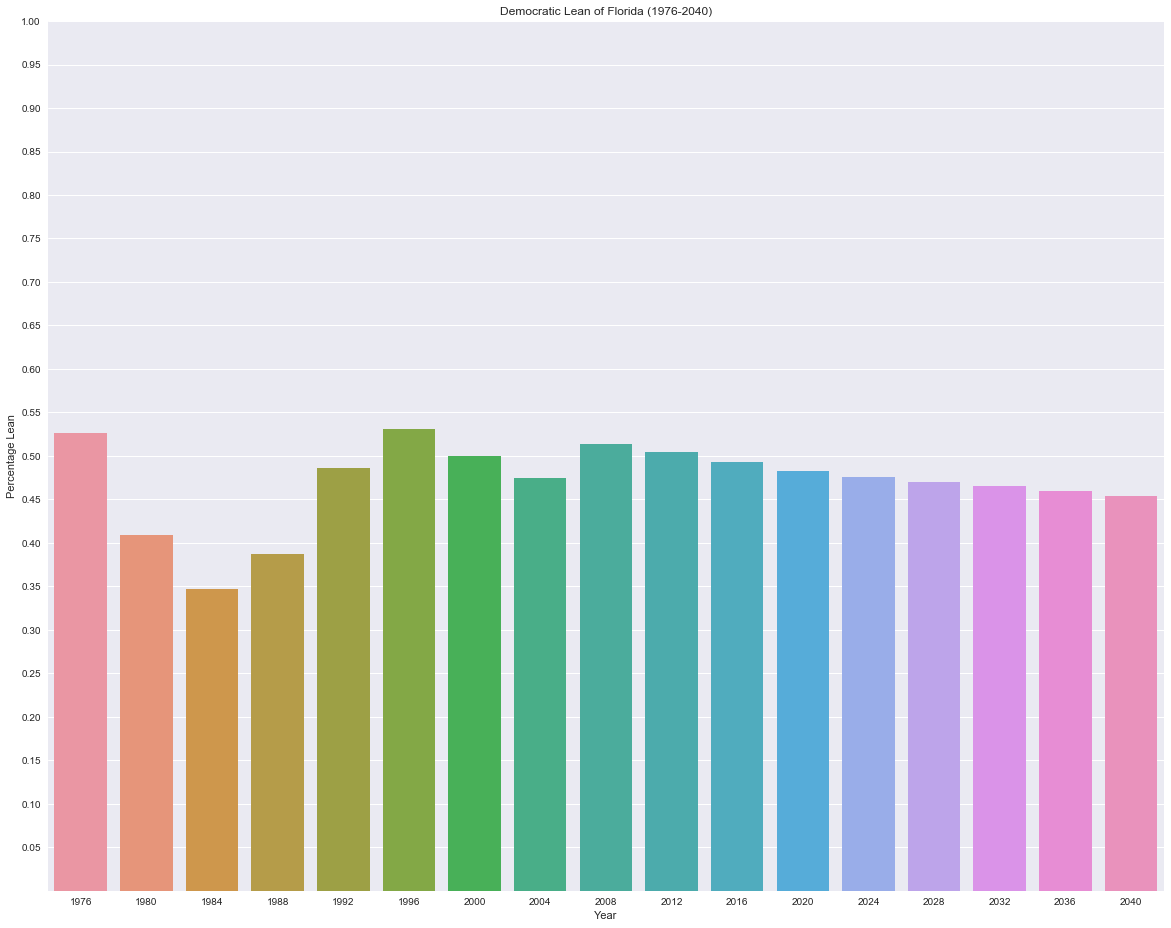

In [21]:
constructBarplot(floridaFrame, 1976, 2044, "Democratic Lean of Florida (1976-2040)")

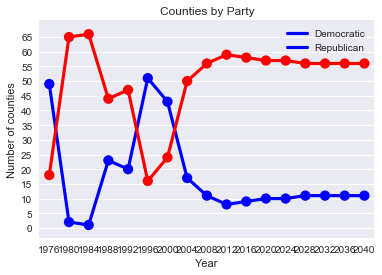

In [22]:
plotSums(floridaFrame)

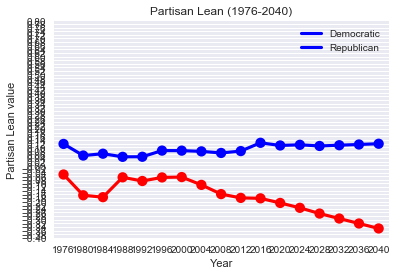

In [23]:
plotLeans(floridaFrame)

In [24]:
oregonFrame = pd.read_csv("OregonResults.csv")
oregonCounties = ['Baker', 'Benton', 'Clackamas', 'Clatsop', 'Columbia', 'Coos', 'Crook', 'Curry', 'Deschutes', 'Douglas', 'Gilliam', 'Grant', 'Harney', 'Hood River', 'Jackson', 'Jefferson', 'Josephine', 'Klamath', 'Lake', 'Lane', 'Lincoln', 'Linn', 'Malheur', 'Marion', 'Morrow', 'Multnomah', 'Polk', 'Sherman', 'Tillamook', 'Umatilla', 'Union', 'Wallowa', 'Wasco', 'Washington', 'Wheeler', 'Yamhill']

In [37]:
counties = pd.read_json('us-counties.json')
points = []
for i in range(len(counties['features'])):
    county = counties.iloc[i]['features']
    name = county["properties"]["name"]
    name = name.strip()
    if(county["id"][0:2] == "41"):
         counties.append(county)
         points.append(county["geometry"]["coordinates"][0])
jsonDict = {"type": "FeatureCollection", "features": counties}
with open('or-counties.json', 'w') as outfile:  
    json.dump(jsonDict, outfile)

TypeError: Can only append a Series if ignore_index=True or if the Series has a name

In [38]:
geo = r'or-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(constructExtendedTreemap, df=fixed(oregonFrame), year=slider, points=fixed(points))
None

In [26]:
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(extendedMap, df=fixed(oregonFrame), year=slider, loc=fixed((44, -121)),zoom=fixed(6))
None

Year: 1976DemTotal: 513757.076155RepTotal: 515264.923845
Year: 1980DemTotal: 526264.034819RepTotal: 654350.965181
Year: 1984DemTotal: 538386.811932RepTotal: 688036.188068
Year: 1988DemTotal: 629013.332371RepTotal: 572036.667629
Year: 1992DemTotal: 824462.85231RepTotal: 637927.14769
Year: 1996DemTotal: 753482.700843RepTotal: 623033.299157
Year: 2000DemTotal: 771997.55734RepTotal: 761364.44266
Year: 2004DemTotal: 956671.866649RepTotal: 879379.133351
Year: 2008DemTotal: 1066607.42131RepTotal: 759917.578686
Year: 2012DemTotal: 1006624.77325RepTotal: 781043.226752
Year: 2016DemTotal: 1121074.88938RepTotal: 874059.110624
Year: 2020DemTotal: 1096974.41957RepTotal: 1003810.47329
Year: 2024DemTotal: 1128929.8842RepTotal: 1077065.65151
Year: 2028DemTotal: 1159013.19904RepTotal: 1152192.97953
Year: 2032DemTotal: 1187650.78089RepTotal: 1228766.04054
Year: 2036DemTotal: 1214956.18334RepTotal: 1306671.28094
Year: 2040DemTotal: 1241558.34416RepTotal: 1385279.76298


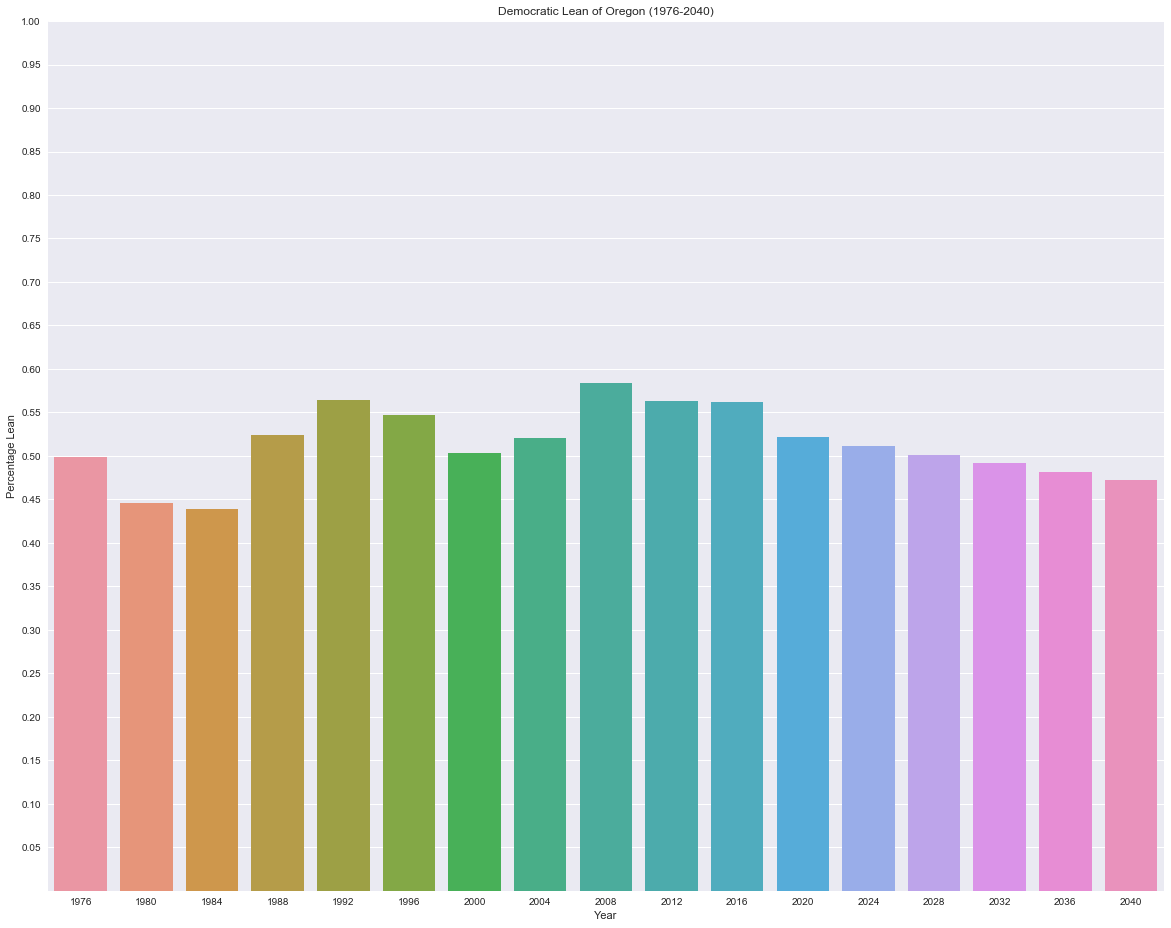

In [27]:
constructBarplot(oregonFrame, 1976, 2044, "Democratic Lean of Oregon (1976-2040)")

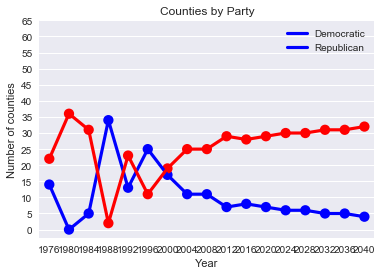

In [28]:
plotSums(oregonFrame)

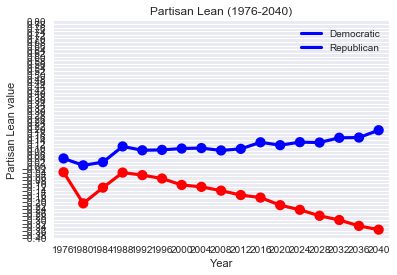

In [29]:
plotLeans(oregonFrame)

In [30]:
illinoisFrame = pd.read_csv('IllinoisResults.csv')
illinoisCounties = ["Adams","Alexander","Bond","Boone","Brown","Bureau","Calhoun","Carroll","Cass","Champaign","Christian","Clark","Clay","Clinton","Coles","Cook","Crawford","Cumberland","De Witt","DeKalb","Douglas","DuPage","Edgar","Edwards","Effingham","Fayette","Ford","Franklin","Fulton","Gallatin","Greene","Grundy","Hamilton","Hancock","Hardin","Henderson","Henry","Iroquois","Jackson","Jasper","Jefferson","Jersey","Jo Daviess","Johnson","Kane","Kankakee","Kendall","Knox","LaSalle","Lake","Lawrence","Lee","Livingston","Logan","Macon","Macoupin","Madison","Marion","Marshall","Mason","Massac","McDonough","McHenry","McLean","Menard","Mercer","Monroe","Montgomery","Morgan","Moultrie","Ogle","Peoria","Perry","Piatt","Pike","Pope","Pulaski","Putnam","Randolph","Richland","Rock Island","Saline","Sangamon","Schuyler","Scott","Shelby","St. Clair","Stark","Stephenson","Tazewell","Union","Vermilion","Wabash","Warren","Washington","Wayne","White","Whiteside","Will","Williamson","Winnebago","Woodford"]

In [31]:
geo = r'il-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(constructExtendedTreemap, df=fixed(illinoisFrame), year=slider)
None

In [39]:
counties = pd.read_json('us-counties.json')
points = []
for i in range(len(counties['features'])):
    county = counties.iloc[i]['features']
    name = county["properties"]["name"]
    name = name.strip()
    if(county["id"][0:2] == "17"):
         points.append(county["geometry"]["coordinates"][0])

In [43]:
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(extendedMap, df=fixed(illinoisFrame), year=slider, loc=fixed((40, -90)),zoom=fixed(6), points=fixed(points))
None

Year: 1976DemTotal: 1766474.40081RepTotal: 1952172.59919
Year: 1980DemTotal: 1597958.04619RepTotal: 2151548.95381
Year: 1984DemTotal: 1071109.5496RepTotal: 1747889.4504
Year: 1988DemTotal: 1669396.5442RepTotal: 1889646.4558
Year: 1992DemTotal: 2267105.28771RepTotal: 1783001.71229
Year: 1996DemTotal: 1847314.00757RepTotal: 1464000.99243
Year: 2000DemTotal: 1958458.58615RepTotal: 1783568.41385
Year: 2004DemTotal: 2204830.35762RepTotal: 2069392.64238
Year: 2008DemTotal: 2697362.42578RepTotal: 1832466.57422
Year: 2012DemTotal: 2323858.06358RepTotal: 1927168.93642
Year: 2016DemTotal: 2515689.51349RepTotal: 2077725.48651
Year: 2020DemTotal: 2491757.74399RepTotal: 2213165.9703
Year: 2024DemTotal: 2541994.83159RepTotal: 2310940.09698
Year: 2028DemTotal: 2593196.41245RepTotal: 2407749.73041
Year: 2032DemTotal: 2646101.18458RepTotal: 2502856.17256
Year: 2036DemTotal: 2704329.57465RepTotal: 2592638.99678
Year: 2040DemTotal: 2769251.44273RepTotal: 2675728.34298


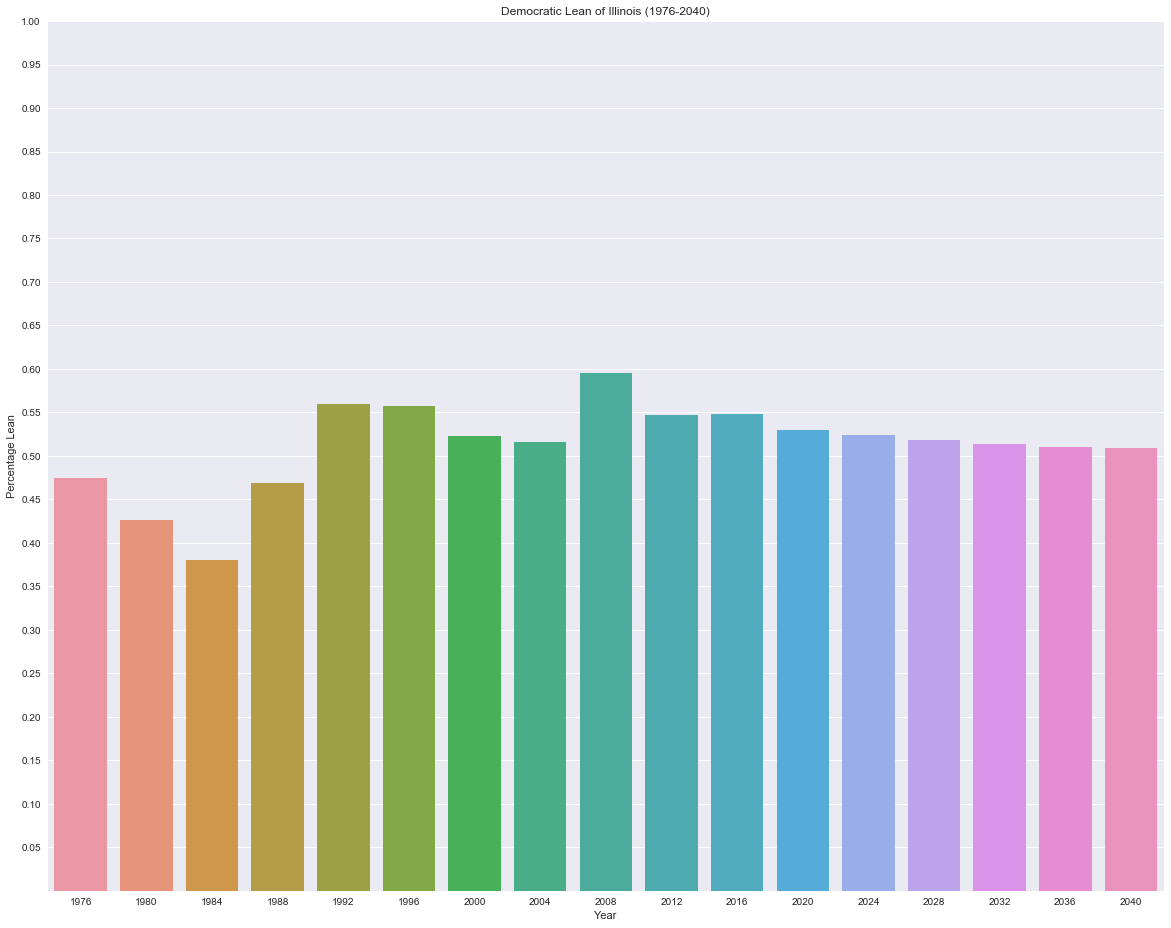

In [44]:
constructBarplot(illinoisFrame, 1976, 2044, "Democratic Lean of Illinois (1976-2040)")

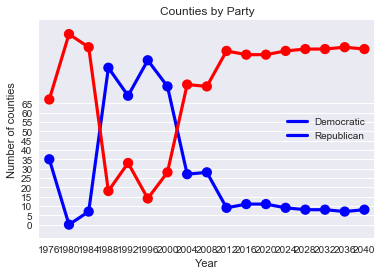

In [45]:
plotSums(illinoisFrame)

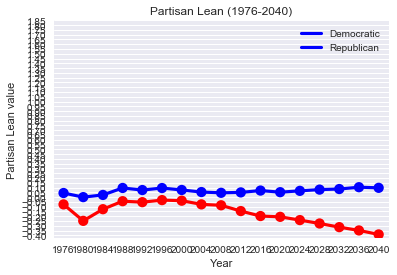

In [48]:
plotLeans(illinoisFrame)